# Evaluación del impacto del balanceo de clases en la segmentación semántica urbana con SegNet en imágenes aéreas de alta resolución
## Entrenamiento con pesos por frecuencia inversa, 10 épocas 

**Estudiante**: Gizela Andrea Guzmán Lugo

Fecha: 12/11/2025

**Objetivo**: Evaluar el impacto de aplicar una estrategia de balanceo de clases mediante pesos por frecuencia inversa en la función de pérdida (CrossEntropyLoss), con el propósito de mejorar el desempeño del modelo en clases minoritarias como muros, las cuales suelen ser subrepresentadas en los datos y difíciles de segmentar por su naturaleza delgada y lineal. Se entrenó durante 10 épocas, manteniendo la misma arquitectura que el experimento base, pero incorporando ponderaciones que penalizan con mayor intensidad los errores en clases poco frecuentes.

Este segundo código implementa la misma arquitectura SegNet utilizada en el entrenamiento base, bajo una configuración estándar. SegNet fue desarrollada originalmente por la Universidad de Cambridge como una red totalmente convolucional tipo encoder–decoder para segmentación densa de imágenes. La implementación se realizó en PyTorch, adaptando la red para procesar imágenes aéreas de muy alta resolución, con el objetivo de clasificar cada píxel según su pertenencia a diferentes clases geoespaciales.

A diferencia del entrenamiento base sin pesos, en esta versión se incorporan pesos de clase calculados mediante la frecuencia inversa, lo que asigna mayor relevancia (penalización) a las clases con menor representación espacial, como muros. Con ello, se busca reducir el sesgo del modelo hacia clases predominantes (por ejemplo, construcciones y árboles) y mejorar la detección de objetos pequeños y delgados, uno de los principales desafíos en la segmentación semántica urbana.

La implementación mantiene el mismo conjunto de datos, basado en las ortoimágenes verdaderas de 10 cm de resolución y cartografía vectorial estructurada bajo los estándares del IGAC, correspondientes a la zona urbana del municipio de Santa Rosa de Osos, Antioquia. Estas fuentes se rasterizaron y adaptaron para su uso como máscaras semánticas multiclase.

Las clases consideradas en esta implementación son:

* Indefinido
* Construcciones
* Árboles
* Vías
* Muros
  
Este trabajo es una implementación de PyTorch de la línea base presentada en ["Más allá de RGB: teledetección urbana de muy alta resolución con redes profundas multimodales "](https://hal.archives-ouvertes.fr/hal-01636145), *Nicolas Audebert*, *Bertrand Le Saux* y *Sébastien Lefèvre*, ISPRS Journal, 2018.


## 1. 🛠️Requisitos técnicos y configuración del entorno

Este notebook requiere la instalación de bibliotecas esenciales para el procesamiento de imágenes aéreas mediante redes neuronales convolucionales, entre las cuales se destacan:`torch`, `scikit-image`, `numpy` y `matplotlib`

La instalación se realiza mediante el archivo requirements_py310.txt, el cual contiene la lista de dependencias con versiones específicas optimizadas para Python 3.10.0, asegurando compatibilidad con PyTorch y CUDA:

Para mejorar el rendimiento del entrenamiento, especialmente en modelos totalmente convolucionales como SegNet, se recomienda disponer de una GPU con soporte CUDA y cuDNN, lo que permite la ejecución paralela de operaciones tensoriales intensivas.

En caso de no contar con GPU, el notebook puede ejecutarse en CPU, aunque con tiempos de entrenamiento significativamente más altos.

In [2]:
# Configuración directorio de trabajo
import os

# Ruta local en Windows
base_path = r"F:\PERCEPCION_R_AVANZADA\Datos_Informe_2"

# Cambiar directorio de trabajo
os.chdir(base_path)

print("Directorio actual:", os.getcwd())


Directorio actual: F:\PERCEPCION_R_AVANZADA\Datos_Informe_2


In [3]:
# Instalación paquetes listados en requirements_py310.txt

import sys
!{sys.executable} -m pip install -r requirements_py310.txt

In [4]:
# Importación librerias 
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
import os, glob, re
from tqdm.auto import tqdm

## 2. ⚙️ Parámetros iniciales del modelo

Se establecen los parámetros básicos para la preparación de datos y configuración del modelo. Estos parámetros controlan el tamaño de los parches,el stride (cuánto se desplaza la ventana al generar parches), el número de canales de las imágenes, la ruta base del dataset y el tamaño de batch para entrenamiento.

* PATCH_SIZE: dimensión de los parches de entrada (ej. 256 × 256 píxeles), seleccionada para equilibrar el detalle espacial y la eficiencia de procesamiento.

* STRIDE: desplazamiento de la ventana deslizante utilizada para generar parches, permitiendo control del solapamiento entre teselas y mejor preservación de bordes y objetos pequeños.

* N_CHANNELS: número de bandas utilizadas como entrada del modelo 

* BATCH_SIZE: número de imágenes procesadas en cada iteración de entrenamiento; influye directamente en el uso de memoria GPU.

* BASE_DIR: ruta principal donde se almacenan las imágenes y las máscaras semánticas.

Asimismo, se definen las clases objetivo que el modelo debe segmentar, representadas mediante códigos numéricos y nombres semánticos (Indefinido,Construcciones, Árboles, Vias, Muros). A partir de esta lista, se calcula automáticamente el número total de clases (N_CLASSES) requerido por la función de pérdida y la capa de salida.

En este modelo inicial (sin balanceo), se asignan pesos uniformes a todas las clases, lo que implica que el modelo aprende únicamente a partir de la frecuencia natural de los datos, sin correcciones para clases minoritarias o de baja representatividad espacial.


In [11]:
# Parametros
WINDOW_SIZE = (256, 256) # Tamaño del patch en píxeles para entrenar/inferir.
STRIDE = 32 # Paso de la ventana para entrenar/inferir.
IN_CHANNELS = 3 # Número de canales de entrada (RGB/IRRG).
FOLDER = "F:/PERCEPCION_R_AVANZADA/Datos_Informe_2" # Ruta conjunto de datos
BATCH_SIZE = 10 # Número de muestras por mini-batch

LABELS = ["Indefinido","Construcciones", "Árboles", "Vias", "Muros"] # Orden y nombres de clases
N_CLASSES = len(LABELS) # Número de clases
CACHE = True # Almacenar el conjunto de datos en la memoria

# conjunto de datos

DATA_FOLDER = FOLDER + '/Mosaicos/mosaico_{}.tif'
LABEL_FOLDER = FOLDER + '/Datos_Etiquetados_RGB/Datos_etiquetados_{}.tif'

## 3. 🗺️Visualización del conjunto de datos

Con el propósito de verificar la coherencia espacial y semántica entre las ortoimágenes y sus respectivas etiquetas, se implementó un bloque de visualización que permite inspeccionar las imágenes originales y sus correspondientes máscaras semánticas codificadas en colores. Esta etapa es fundamental para garantizar que los datos estén correctamente estructurados antes del entrenamiento del modelo.

Se definió un diccionario (palette) que asigna a cada ID de clase un color RGB, permitiendo visualizar las clases con representación cromática.

Como el conjunto de datos se almacena en formato RGB, se necesita definir la paleta de colores que pueda asignar el ID de la etiqueta a su color RGB. Para ello se definen dos funciones auxiliares para convertir de valores numéricos a colores y viceversa.

**Cambios al codigo original**

Se implementa una función mejorada para la conversión de máscaras RGB a etiquetas numéricas, incorporando un mecanismo de tolerancia espectral. A diferencia del código original, que realiza una coincidencia estricta entre los valores RGB del píxel y los definidos en la paleta, esta versión permite una variación de ±2 unidades en cada canal de color (tol=2). Esta mejora es especialmente importante al trabajar con imágenes provenientes de procesos de rasterización, compresión o exportación desde SIG, donde los valores RGB originales pueden sufrir pequeñas alteraciones (por ejemplo, de 255 a 253 o 254), que en un esquema rígido impedirían que el píxel sea identificado correctamente. Gracias al uso de esta tolerancia, el código es capaz de reconocer correctamente las clases aun cuando existan ligeras variaciones cromáticas.

Adicionalmente, se implementa un control automático para imágenes con canal alfa (RGBA), eliminando el cuarto canal cuando está presente, situación común en archivos TIFF, o productos generados por SIG. Esta corrección evita errores en la conversión y garantiza que el formato de entrada al modelo permanezca en el estándar H×W×3. 

Finalmente, la función retorna la máscara en formato int64, adecuado para PyTorch y necesario para operaciones de clasificación multiclase, mientras que el primer código empleaba uint8, que puede generar conflictos en el cálculo de la función de pérdida (CrossEntropyLoss).


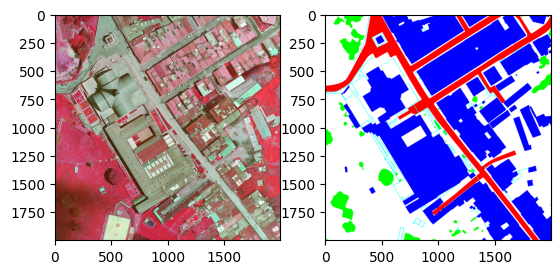

Ground truth in numerical format has shape (2000,2000) : 
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]]


In [6]:
# Paleta de colores
palette = {
    0 : (255, 255, 255),  # Indefinido
    1 : (0, 0, 255),      # Edificios (azul)
    2 : (0, 255, 0),      # Árboles (verde)
    3 : (255, 0, 0),      # Vias (rojo)
    4 : (0, 255, 255),    # Muros (cian)
  }

# invierte el dict para hacer color → índice.
invert_palette = {v: k for k, v in palette.items()}

# Convierte una máscara numérica (HxW con valores 0..6) a RGB aplicando la paleta por clase
def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    # Se crea una matriz vacía de 3 canales (HxWx3) para almacenar los colores RGB
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)
    
    # Recorre cada par (c: clase, i: color RGB) de la paleta definida
    for c, i in palette.items():
        # Genera una máscara booleana que identifica los píxeles que pertenecen a la clase c
        m = arr_2d == c
        # Asigna el color RGB correspondiente (i) a todos los píxeles que cumplen la condición anterior
        arr_3d[m] = i
    # Retorna la imagen final con colores codificados por clase
    return arr_3d

# Convierte una máscara en color (HxWx3) a índices comparando píxel a píxel con cada color de la paleta
def convert_from_color(arr_3d, palette=invert_palette, tol=2):
    """
    Convierte máscara RGB (H,W,3) a índices (H,W)
    tolerando pequeñas variaciones (±tol).
    """
    # Asegura que el array tenga formato uint8 (0-255 por canal)
    arr_3d = np.asarray(arr_3d, dtype=np.uint8)
    # Si ya está en formato numérico (HxW), no se transforma
    if arr_3d.ndim == 2:
        return arr_3d
    # Si tiene 4 canales (ej. RGBA), elimina el canal alfa
    if arr_3d.shape[2] == 4:
        arr_3d = arr_3d[:,:,:3]
    # Obtiene las dimensiones de la imagen (alto y ancho)
    H, W = arr_3d.shape[:2]
    # Crea una matriz vacía donde se almacenarán los índices de clase (salida final)
    arr_2d = np.zeros((H, W), dtype=np.int64)
    
    # Recorre cada color definido en la paleta y su ID asociado
    for rgb, idx in palette.items():
        r, g, b = rgb
        mask = (
            (np.abs(arr_3d[:,:,0].astype(int) - r) <= tol) &
            (np.abs(arr_3d[:,:,1].astype(int) - g) <= tol) &
            (np.abs(arr_3d[:,:,2].astype(int) - b) <= tol)
        )
        # Asigna el ID de clase (índice) a los píxeles que cumplen la condición
        arr_2d[mask] = idx
    # Retorna la matriz final con los IDs de clase
    return arr_2d

# Carga y visualización imagen
img = io.imread(r'F:\PERCEPCION_R_AVANZADA\Datos_Informe_2\Mosaicos\mosaico_13.tif')
fig = plt.figure()
fig.add_subplot(121)
img = img.astype(np.uint8)
plt.imshow(img)


# Carga y visualización imagen con etiquetas (verdad fundamental)
gt = io.imread(r'F:\PERCEPCION_R_AVANZADA\Datos_Informe_2\Datos_Etiquetados_RGB\Datos_etiquetados_13.tif')
fig.add_subplot(122)
plt.imshow(gt)
plt.show()

# Conversión de la verdad fundamental en un formato de matriz
array_gt = convert_from_color(gt)
print("Ground truth in numerical format has shape ({},{}) : \n".format(*array_gt.shape[:2]), array_gt)


## 4. 📉Creación de funciones

Para la implementación del modelo de segmentación semántica, fue necesario definir un conjunto de funciones auxiliares que permiten gestionar el muestreo de datos, el cálculo de la pérdida, la evaluación del rendimiento y la implementación de la inferencia mediante ventanas deslizantes. A continuación, se describen sus propósitos y características principales:

* get_random_pos: Selecciona de manera aleatoria una posición (x, y) dentro de una imagen grande, desde la cual se recorta un parche (tile) de tamaño w × h. Esta función se utiliza durante el entrenamiento, ya que permite muestrear múltiples regiones de la imagen y evita que el modelo aprenda únicamente patrones repetitivos o centrados.

* CrossEntropy2d: Función personalizada que adapta la Cross-Entropy Loss para tensores 2D o 4D con forma (N, C, H, W). La función aplana las predicciones (logits) y las etiquetas para calcular la pérdida por píxel.

* accuracy: Calcula la exactitud global (Overall Accuracy) comparando los pixeles predichos correctamente con el total de pixeles evaluados. Se expresa como un porcentaje y sirve como una primera medida del rendimiento del modelo.

* sliding_window / count_sliding_window: Estas funciones implementan el método de ventana deslizante (sliding window), el cual permite recorrer imágenes completas dividiéndolas en parches de tamaño fijo, con un paso o desplazamiento definido (stride) en prueba/inferencia. Ajustan bordes para cubrir toda la imagen.

* grouper: Divide un iterador en subgrupos (lotes o batches) de tamaño n. Esto permite procesar las ventanas generadas mediante sliding_window en lotes, optimizando el uso de memoria y acelerando la inferencia.

* metrics: Genera indicadores clave de desempeño del modelo, tales como:

| Métrica                      | Descripción                                                                                           |
| ---------------------------- | ----------------------------------------------------------------------------------------------------- |
| Matriz de confusión          | Representa los aciertos y errores por clase, mostrando cómo el modelo confunde unas clases con otras. |
| Accuracy (Exactitud global)  | Porcentaje de píxeles correctamente clasificados sobre el total de píxeles evaluados.                 |
| F1-score por clase           | Mide el equilibrio entre precisión y sensibilidad. Útil especialmente para clases minoritarias.       |
| IoU por clase                | Evalúa el solapamiento entre la predicción y la verdad terreno para cada clase (intersección/unión).  |
| mIoU (mean IoU)              | Promedio del IoU de todas las clases.           |
| Kappa (Coeficiente de Cohen) | Mide el nivel de acuerdo entre predicción y verdad terreno, considerando el azar.                     |


**Cambios al codigo original**

En esta versión del código se incorporaron dos métricas adicionales: IoU (Intersection over Union) por clase y mIoU (mean IoU). Estas métricas permiten evaluar con mayor precisión la calidad espacial de la segmentación, especialmente en contextos donde el Accuracy puede resultar engañoso debido al desbalance de clases. El IoU calcula el grado de coincidencia entre la predicción del modelo y la verdad terreno, considerando tanto los aciertos como los errores por omisión y comisión. Esto lo convierte en un indicador más riguroso y adecuado para evaluar la segmentación semántica de objetos geográficos.

In [12]:
# Devuelve coordenadas para recortar un patch aleatorio w×h dentro de img
def get_random_pos(img, window_shape):
    """ Extracto de un parche aleatorio 2D de forma window_shape en la imagen """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

# Adapta cross_entropy a tensores 2D (clasificación) 
def CrossEntropy2d(input, target, weight=None, size_average=True):
    """ Versión 2D de la pérdida de entropía cruzada """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target,weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

# Precisión global [%] con NumPy.
def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size
    
# Genera coordenadas (fila, col) y tamaño del patch al recorrer con “stride”.
def sliding_window(top, step=10, window_size=(20,20)):
    """ Desliza una ventana window_shape a través de la imagen  """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
# Cuenta cuántas ventanas se generan
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Cuenta el número de ventanas en una imagen """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

# Corta en partes un iterador en lotes de tamaño n (útil para procesar ventanas por lotes).
def grouper(n, iterable):
    """ Explora un iterador por fragmento de n elementos """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

# Función que imprime y devuelve métricas básicas:
#Matriz de confusión multi-clase, Accuracy global, F1 por clase (macro sin promedio final) y Kappa
def metrics(predictions, gts, label_values=LABELS):
    cm = confusion_matrix(gts.ravel().astype(np.int64),
                      predictions.ravel().astype(np.int64),
                      labels=np.arange(len(label_values), dtype=np.int64))

    print("Confusion matrix :")
    print(cm)

    print("---")

    # Calculó de la precisión global
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))

    print("---")

    # Cálculo F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")

    # Cálculo coeficiente kappa
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))

     # IoU por clase y mIoU 
    tp = np.diag(cm).astype(np.float64)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    denom = tp + fp + fn
    with np.errstate(divide='ignore', invalid='ignore'):
        iou_per_class = np.where(denom > 0, tp / denom, np.nan)
    miou = np.nanmean(iou_per_class)

    print("IoU por clase :")
    for l_id, iou in enumerate(iou_per_class):
        print("{}: {}".format(label_values[l_id], iou))
    print("mIoU :", miou)
    print("---")

    return accuracy

## 5. 📂 Cargue y preprocesamiento del conjunto de datos

En esta sección se define la clase Dataset, implementada a partir de ```torch.utils.data.Dataset```, la cual gestiona la preparación de los mosaicos de ortoimágenes y sus máscaras etiquetadas, garantizando que la información sea compatible con los requerimientos del modelo SegNet. Esta clase permite leer los archivos de entrada, normalizar los valores espectrales en el rango [0,1], y convertir las etiquetas de color RGB a matrices numéricas, donde cada píxel representa la clase semántica asignada (construcciones, vías, muros, árboles, indefinido).

Dado que los mosaicos originales tienen una resolución muy alta (2000 × 2000 píxeles), lo que resultaría limitado para el procesamiento en GPU, se implementa un muestreo espacial basado en extracción de parches aleatorios de 128 × 128 píxeles. Este enfoque permite no solo optimizar el uso de memoria, sino también asegurar que el modelo aprenda patrones locales representativos de la morfología urbana (techos, bordes, muros, corredores viales, vegetación adyacente, sombras, etc.).

Para mejorar la robustez del modelo y su capacidad de generalización, la clase Dataset incorpora técnicas de aumento de datos (data augmentation), aplicadas dinámicamente en cada solicitud de muestra. Se incluyen transformaciones geométricas como volteos horizontales y verticales, rotaciones simples e inversiones espectrales, conservando la correspondencia espacial entre la imagen y su etiqueta. Esto es especialmente útil para mejorar el aprendizaje en clases minoritarias, que están subrepresentadas en el conjunto de datos.

Finalmente, cada vez que el modelo solicita una muestra durante el entrenamiento o la validación, la clase devuelve un par (imagen, etiqueta) completamente preprocesado, con dimensiones ajustadas, normalizado, etiquetado numéricamente y con aumento de datos, listo para ser procesado por la arquitectura SegNet.


In [13]:
# Clase de conjunto de datos

# Define cómo se generan parches aleatorios para entrenar a partir de las tiles 

class dataset(torch.utils.data.Dataset):
#__init__ — el “constructor”
# Se ejecuta una sola vez cuando se crea el objeto
# Sirve para configurar tu clase: guardar parámetros, preparar rutas, crear capas, etc
    
    def __init__(self, ids, data_files=DATA_FOLDER, label_files=LABEL_FOLDER,
                            cache=False, augmentation=True):
        super(dataset, self).__init__()

        self.augmentation = augmentation
        self.cache = cache

        # Lista de archivos
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in ids]

        # Comprobación: genera un error si algunos archivos no existen
        for f in self.data_files + self.label_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))

        # Inicializar diccionarios de caché
        self.data_cache_ = {}
        self.label_cache_ = {}


    def __len__(self):
        # El tamaño de época predeterminado es 10 000 muestras
        return 10000

    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True

        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))

        return tuple(results)
        
# __getitem__ — acceso por índice
# Define qué devuelve el objeto cuando se hace obj[i].
    
    def __getitem__(self, i):
        # Elige una imagen al azar
        random_idx = random.randint(0, len(self.data_files) - 1)

        # # Si el mosaico aún no se ha cargado, póngalo en caché
        if random_idx in self.data_cache_.keys():
            data = self.data_cache_[random_idx]
        else:
            # Los datos están normalizados en [0, 1]
            data = 1/255 * np.asarray(io.imread(self.data_files[random_idx]).transpose((2,0,1)), dtype='float32')
            if self.cache:
                self.data_cache_[random_idx] = data

        if random_idx in self.label_cache_.keys():
            label = self.label_cache_[random_idx]
        else:
            # Las etiquetas se convierten de RGB a sus valores numéricos
            label = np.asarray(convert_from_color(io.imread(self.label_files[random_idx])), dtype='int64')
            if self.cache:
                self.label_cache_[random_idx] = label

        # Obtener un parche aleatorio
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]

        # Aumento de datos
        data_p, label_p = self.data_augmentation(data_p, label_p)

        # Devuelve los valores del torch.Tensor
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))

## 6. 🧠 Definición de la red: Arquitectura SegNet

La arquitectura implementada corresponde a una red totalmente convolucional (Fully Convolutional Network, FCN) basada en el modelo SegNet, diseñado específicamente para tareas de segmentación semántica pixel a pixel. SegNet se caracteriza por su estructura de encoder–decoder simétrica, que permite preservar la información espacial de los objetos presentes en la imagen. 

La red acepta como entrada un tensor con las dimensiones (batch_size, canales, alto, ancho) y devuelve una salida con la forma (N_CLASES, H, W), donde cada píxel contiene un vector de puntuaciones (logits) que representa la probabilidad de pertenecer a cada clase.

1. Encoder: El encoder está compuesto por cinco bloques convolucionales, donde cada bloque contiene capas en la secuencia Convolution → Batch Normalization → ReLU → MaxPool2d(return_indices=True)
   
    * Conv2d: Extrae características espaciales y texturales
    * BatchNorm2d: Estabiliza el entrenamiento, evita explosión de gradientes
    * ReLU: Introduce no linealidad
    * MaxPool2d: Reduce el tamaño espacial y retiene los índices de activación

2. Decoder: El decoder está diseñado de manera espejo al encoder. Cada bloque contiene MaxUnpool2d(indices) → Convolution → BatchNorm2d → ReLU

    * MaxUnpool2d: Reconstruye el tamaño espacial usando los índices almacenados
    * Conv2d: Refina detalles y bordes recuperados
    * BatchNorm2d: Normaliza activaciones para estabilizar el refinamiento
    * ReLU: Mantiene la no linealidad y suaviza bordes

3. Cabeza de clasificación: La última capa es una convolución 1×1 con número de filtros igual al número de clases (N_CLASSES). Esta capa convierte el mapa de características final en un conjunto de logits por píxel, generando una salida con dimensiones (batch_size, N_CLASSES, H, W). Cada píxel contiene un vector con la probabilidad de que dicho píxel pertenezca a una clase determinada.

In [14]:
class SegNet(nn.Module):
    # Red SegNet 
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal(m.weight.data)

    def __init__(self, in_channels=IN_CHANNELS, out_channels=N_CLASSES):
        super(SegNet, self).__init__()
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)

        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)

        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)

        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)

        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)

        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_bn = nn.BatchNorm2d(512)

        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)

        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)

        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)

        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)

        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, out_channels, 3, padding=1)

        self.apply(self.weight_init)

# Define el recorrido de datos por la red
    def forward(self, x):
        # Encoder block 1
        x = self.conv1_1_bn(F.relu(self.conv1_1(x)))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x)))
        x, mask1 = self.pool(x)

        # Encoder block 2
        x = self.conv2_1_bn(F.relu(self.conv2_1(x)))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x)))
        x, mask2 = self.pool(x)

        # Encoder block 3
        x = self.conv3_1_bn(F.relu(self.conv3_1(x)))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x)))
        x, mask3 = self.pool(x)

        # Encoder block 4
        x = self.conv4_1_bn(F.relu(self.conv4_1(x)))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x)))
        x, mask4 = self.pool(x)

        # Encoder block 5
        x = self.conv5_1_bn(F.relu(self.conv5_1(x)))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x)))
        x, mask5 = self.pool(x)

        # Decoder block 5
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x)))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x)))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x)))

        # Decoder block 4
        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x)))
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x)))
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x)))

        # Decoder block 3
        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x)))
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x)))
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x)))

        # Decoder block 2
        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x)))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x)))

        # Decoder block 1
        x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x)))
        x = F.log_softmax(self.conv1_1_D(x), dim=1)
        return x

Después se instancia la red usando los parámetros especificados. Por defecto, los pesos se inicializarán usando la política [He policy](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf).

In [15]:
# instanciar la red
net = SegNet()

## 7. 📎Descarga de pesos pre-entrenados

Para inicializar la red, se utilizan los pesos preentrenados de VGG-16 sobre el conjunto de datos ImageNet, los cuales se transfieren al encoder de SegNet. Este paso es opcional pero altamente recomendable, ya que permite que el modelo comience con conocimiento previo sobre patrones visuales básicos, como bordes, texturas, sombras y estructuras geométricas, comunes tanto en imágenes naturales como en imágenes aéreas.

Dado que SegNet comparte la misma estructura del encoder que VGG-16, es posible reutilizar directamente sus pesos en las capas convolucionales. No obstante, algunos pesos especialmente los correspondientes a las capas totalmente conectadas de VGG-16 no tienen correspondencia en SegNet, por lo que son omitidos durante la carga. PyTorch permite realizar esta importación de manera controlada mediante la opción strict=False, conservando únicamente los pesos compatibles.

In [16]:
import os
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener

# Descarga pesos VGG-16 desde PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth', weights_only=True, map_location='cpu')
mapped_weights = {}
for k_vgg, k_segnet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        mapped_weights[k_segnet] = vgg16_weights[k_vgg]
        print("Mapping {} to {}".format(k_vgg, k_segnet))
        
try:
    net.load_state_dict(mapped_weights)
    print("Loaded VGG-16 weights in SegNet !")
except:
    # Ignora claves faltantes
    pass

Mapping features.0.weight to conv1_1.weight
Mapping features.0.bias to conv1_1.bias
Mapping features.1.weight to conv1_1_bn.weight
Mapping features.1.bias to conv1_1_bn.bias
Mapping features.1.running_mean to conv1_1_bn.running_mean
Mapping features.1.running_var to conv1_1_bn.running_var
Mapping features.3.weight to conv1_1_bn.num_batches_tracked
Mapping features.3.bias to conv1_2.weight
Mapping features.4.weight to conv1_2.bias
Mapping features.4.bias to conv1_2_bn.weight
Mapping features.4.running_mean to conv1_2_bn.bias
Mapping features.4.running_var to conv1_2_bn.running_mean
Mapping features.7.weight to conv1_2_bn.running_var
Mapping features.7.bias to conv1_2_bn.num_batches_tracked
Mapping features.8.weight to conv2_1.weight
Mapping features.8.bias to conv2_1.bias
Mapping features.8.running_mean to conv2_1_bn.weight
Mapping features.8.running_var to conv2_1_bn.bias
Mapping features.10.weight to conv2_1_bn.running_mean
Mapping features.10.bias to conv2_1_bn.running_var
Mapping fe

## 8. 💻 Cargue de la red en la GPU

Antes de iniciar el entrenamiento, es necesario verificar la disponibilidad de una GPU con soporte CUDA, ya que las operaciones de segmentación semántica involucran tensores de alta dimensión y grandes volúmenes de datos, lo cual resulta computacionalmente costoso cuando se ejecuta únicamente en CPU.

Para ello, se utiliza ```torch.cuda.is_available()``` para confirmar si PyTorch ha detectado correctamente una GPU, y posteriormente se envía el modelo (net) a la memoria de la GPU mediante ```net.cuda()```. Este paso es fundamental para acelerar los procesos de entrenamiento e inferencia, reducir los tiempos de cómputo y aprovechar el paralelismo masivo de la GPU.

In [11]:
import sys, torch
# Muestra la ruta del intérprete de Python que se está utilizando
print(sys.executable)
# Verifica si CUDA está disponible y muestra la versión detectada por PyTorch
print("CUDA:", torch.cuda.is_available(), " build:", torch.version.cuda)

C:\Users\USER\anaconda3\envs\torchgpu\python.exe
CUDA: True  build: 12.1


In [12]:
# Envía la red neuronal (modelo) a la GPU
net.cuda()

SegNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1_bn): BatchNorm2d(256, eps=1e-05, mom

## 9. 🔽 Construcción del conjunto de entrenamiento y prueba

Para entrenar y evaluar el modelo de segmentación semántica, se realiza una división del dataset en dos subconjuntos: entrenamiento (train) y prueba (test).

La división se realiza con el objetivo de asegurar que el conjunto de prueba incluya áreas que no fueron observadas durante el entrenamiento, permitiendo evaluar la capacidad del modelo para generalizar en distintas morfologías urbanas y condiciones cartográficas.

**Cambios al codigo original**

En el Código original la carga de los datos depende explícitamente de la estructura del dataset ISPRS. La división entre entrenamiento y prueba se realiza parcialmente de forma manual, definiendo listas específicas o muestreando aleatoriamente IDs. Sin embargo, este enfoque no valida si las imágenes y sus etiquetas están correctamente emparejadas, lo cual puede generar inconsistencias o pérdida de archivos.

Este código propone una estrategia más robusta y adaptable al contexto real del proyecto, donde los datos han sido generados por el usuario. Se hace una búsqueda explícita de imágenes y etiquetas en carpetas diferenciadas, se extraen los IDs directamente desde los nombres de archivo y se verifica la correspondencia real entre imagen–etiqueta usando operaciones de conjuntos. Posteriormente, se realiza una división aleatoria reproducible (70/30), y se crean DataLoader separados para entrenamiento y prueba, incluyendo ``shuffle`` y ``batch_size``, optimizando el rendimiento y la correcta evaluación del modelo.

In [13]:
# Buscar los archivos reales en disco 
image_files = sorted(glob.glob(os.path.join(FOLDER, "Mosaicos", "mosaico_*.*")))
label_files = sorted(glob.glob(os.path.join(FOLDER, "Datos_Etiquetados_RGB", "datos_etiquetados_*.*")))

# Extraer IDs numéricos o de texto de los nombres de archivo 
# Ejemplo: "Datos_etiquetados_3.TIF" -> "3"
label_ids = [os.path.splitext(os.path.basename(f))[0].split('datos_etiquetados_')[-1] for f in label_files]
image_ids = [os.path.splitext(os.path.basename(f))[0].split('mosaico_')[-1] for f in image_files]

#  Filtrar solo IDs que estén en ambos conjuntos
all_ids = sorted(list(set(label_ids) & set(image_ids)))

# División entrenamiento / prueba (70/30) 
random.shuffle(all_ids)
split_idx = int(len(all_ids) * 0.7)
train_ids = all_ids[:split_idx]
test_ids = all_ids[split_idx:]

print("Tiles for training:", train_ids)
print("Tiles for testing:", test_ids)

# Crear datasets y dataloaders 
train_set = dataset(train_ids, cache=CACHE)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

test_set = dataset(test_ids, cache=CACHE)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

Tiles for training: ['32', '17', '36', '28', '10', '43', '1', '12', '13', '7', '0', '6', '41', '9', '21', '23', '37', '16', '18', '35', '5', '27', '25', '8', '15', '30', '11', '45', '4', '38', '20', '39']
Tiles for testing: ['22', '2', '40', '34', '24', '33', '42', '3', '31', '19', '14', '26', '44', '29']


## 10. 🧮Diseño del optimizador

Para el entrenamiento de la red SegNet, se implementó una configuración basada en el algoritmo Stochastic Gradient Descent (SGD), con momentum y regularización L2 (weight_decay), una combinación ampliamente utilizada en tareas de segmentación semántica debido a su estabilidad y capacidad de prevenir sobreajuste.

Dado que el modelo emplea pesos preentrenados en ImageNet para el codificador (encoder) y pesos aleatorios en el decodificador (decoder), se implementó un aprendizaje con tasas diferenciadas (differential learning rates), de modo que cada bloque aprenda a una velocidad adecuada según su nivel de conocimiento previo.

El codificador se entrena a la mitad de la tasa de aprendizaje del decodificador, ya que se utilizan los pesos VGG-16 preentrenados. Aprendizaje con LR diferenciado.

* Decoder (*_D): lr = 0.01 porque se inicializa aleatorio y necesita aprender más rápido.

* Encoder (resto): lr = 0.005 porque parte de pesos preentrenados VGG-16 y solo se optimiza.

Se utilizó el optimizador SGD con momentum = 0.9, que ayuda a suavizar las actualizaciones y evitar oscilaciones bruscas. Además, se aplicó weight_decay = 5e-4, lo que actúa como regularización L2, reduciendo el riesgo de sobreajuste y favoreciendo la generalización del modelo.

Con el fin de mejorar la estabilidad del entrenamiento y permitir un ajuste más fino en etapas avanzadas, se empleó ``torch.optim.lr_scheduler``, que reduce la tasa de aprendizaje en un factor de γ = 0.1 en las épocas 25, 35 y 45.


In [17]:
# Aprendizaje base (learning rate nominal) para el decodificador
base_lr = 0.01
# Extrae los parámetros de la red y los almacena en un diccionario con sus nombres
params_dict = dict(net.named_parameters())
params = []

# Asignación diferenciada de Learning Rate (LR)
for key, value in params_dict.items():
    if '_D' in key:
        # Los pesos del decodificador se entrenan a la tasa de aprendizaje nominal
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Los pesos del codificador se entrenan en lr / 2 (tenemos pesos VGG-16 como inicialización)
        params += [{'params':[value],'lr': base_lr / 2}]
        
# Definición del optimizador SGD con momentum y regularización L2 (weight decay)
optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)

# Scheduler que reduce la LR un factor de gamma=0.1 en las épocas 25, 35 y 45
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 35, 45], gamma=0.1)

## 11. 📊 Función de testeo

La función ``test()`` implementa la inferencia del modelo mediante ventanas deslizantes (sliding window) y permite evaluar su desempeño sobre imágenes completas, acumulando predicciones y calculando métricas globales.

1) Carga la ortoimagen y sus etiquetas
2) Extrae parches, los envía a la red en GPU y acumula los logits en la cuadrícula de salida para promediar las zonas de solape
3) Obtiene la predicción final por argmax y muestra un panel de progreso con imagen, predicción en color y etiqueta
4) Actualiza las métricas globales (exactitud y matriz de confusión asociada)

**Cambios al codigo original**

En esta implementación, se incorpora una validación condicional para detectar si la verdad terreno viene en formato RGB (HxWx3). Si es así, se convierte a una matriz numérica H×W mediante la función convert_from_color. Esto permite trabajar tanto con etiquetas rasterizadas en color como con máscaras ya codificadas numéricamente, mejorando la compatibilidad del modelo con datos geoespaciales reales y evitando conversiones innecesarias o errores por diferencias en la estructura de canales.

In [18]:
def test(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
    # Utiliza la red en el conjunto de pruebas
    test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids)
    test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
  
    all_preds = []
    all_gts = []
    
    # Cambiar la red al modo de inferencia
    net.eval()
  

    for img, gt in tqdm(zip(test_images, test_labels), total=len(test_ids), leave=False):

          # Convertir GT RGB (3 canales) a índices (HxW) 
        if gt.ndim == 3:
           gt = convert_from_color(gt).astype(np.int64)
           gt_vis = convert_to_color(gt) 

        # inferencia por ventanas
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))
        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Mostrar resultados en progreso
            if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
                    _pred = np.argmax(pred, axis=-1)
                    fig = plt.figure()
                    fig.add_subplot(1,3,1)
                    plt.imshow(np.asarray(255 * img, dtype='uint8'))
                    fig.add_subplot(1,3,2)
                    plt.imshow(convert_to_color(_pred))
                    fig.add_subplot(1,3,3)
                    plt.imshow(gt)
                    clear_output()
                    plt.show()
                    
            # Construir el tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            image_patches = torch.from_numpy(image_patches).float().cuda()
            
            # Hacer la inferencia
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            
            # Completa la matriz de resultados
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        pred = np.argmax(pred, axis=-1)

        # Muestra el resultado
        clear_output()
        fig = plt.figure()
        fig.add_subplot(1,3,1)
        plt.imshow(np.asarray(255 * img, dtype='uint8'))
        fig.add_subplot(1,3,2)
        plt.imshow(convert_to_color(pred))
        fig.add_subplot(1,3,3)
        plt.imshow(gt)
        plt.show()

        all_preds.append(pred)
        all_gts.append(gt)

        clear_output()
        
        # Calcula algunas métricas
        metrics(pred.ravel(), gt.ravel())
        accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([g.ravel() for g in all_gts]).ravel())

    if all:
        return accuracy, all_preds, all_gts
    else:
        return accuracy

## 12. ⚖️ BALANCEO DE CLASES

**Cambios al codigo base**

En problemas de segmentación semántica, como en este caso aplicado a zonas urbanas, es común que las clases no aparezcan con la misma frecuencia. Esta disparidad provoca que el modelo “ignore” las clases minoritarias, privilegiando las más abundantes, lo cual afecta de forma crítica la detección de objetos pequeños o lineales. Para mitigar este problema, se implementó una estrategia de balanceo de clases mediante pesos inversamente proporcionales a la frecuencia de aparición. Primero, se calcula un histograma de densidad de clases a partir de los datos de entrenamiento. Luego, con base en esas frecuencias, se construyen pesos normalizados que penalizan más los errores en clases poco frecuentes, forzando al modelo a prestarles mayor atención durante el entrenamiento.

Esta estrategia beneficia directamente la segmentación de objetos pequeños y estructuralmente importantes en cartografía urbana, contribuyendo a mejorar la coherencia espacial y la calidad semántica de las predicciones. Finalmente, los pesos calculados se integran en la función de pérdida CrossEntropyLoss, permitiendo un aprendizaje más equilibrado y robusto.

In [16]:
# BALANCEO DE CLASES POR FRECUENCIA INVERSA

IGNORE_INDEX = 255  # valor para píxeles sin etiqueta
USE_MEDIAN_FREQ = False  #Inverse Frequency Balancing; True: median frequency balancing

def compute_class_histogram(ids, num_classes, label_fmt):
    hist = np.zeros(num_classes, dtype=np.int64) # Inicializa contador de clases
    for id_ in ids:
        # Cargar etiqueta raster
        gt = np.asarray(io.imread(label_fmt.format(id_)))
        
        # Si la GT está en RGB, se convierte a índices numéricos
        if gt.ndim == 3:
            gt = convert_from_color(gt)
        # Ignorar los píxeles con etiqueta 255 (sin clase asignada)
        mask = (gt != IGNORE_INDEX)
        if mask.any():
            # np.unique: cuenta cuántos píxeles hay de cada clase
            vals, cnts = np.unique(gt[mask], return_counts=True)
            for v, c in zip(vals, cnts):
                if 0 <= v < num_classes:
                    hist[v] += c
    return hist
    
# Calcular histograma de clases en datos de entrenamiento
hist = compute_class_histogram(train_ids, N_CLASSES, LABEL_FOLDER)
Convertir histograma a frecuencias relativas (0 a 1)
freq = hist / np.maximum(1, hist.sum())

eps = 1e-6

# Estrategias de generación de pesos
if USE_MEDIAN_FREQ and np.any(freq > 0): # Equilibrio de frecuencia media
    median = np.median(freq[freq > 0])
    weights_np = median / np.maximum(freq, eps)
else:
    inv = 1.0 / np.maximum(freq, eps) # Inverso de la frecuencia
    weights_np = inv / inv.sum() * N_CLASSES  # normaliza para que promedio≈1
    
#Evitar pesos demasiado extremos (limitarlos)
weights_np = np.clip(weights_np, 0.1, 10.0) 
# Convertir a tensor PyTorch
WEIGHTS = torch.tensor(weights_np, dtype=torch.float32)

print("Pesos por clase:", np.round(weights_np, 6).tolist())


Pesos por clase: [0.1, 0.1, 0.277003, 0.253949, 4.367469]


## 13. 🔄Bucle de entrenamiento

El proceso de entrenamiento comienza poniendo la red en modo entrenamiento ``(net.train())``, de manera que PyTorch active el cálculo de gradientes. En cada época, el modelo recorre secuencialmente los lotes proporcionados por el ``train_loader``. Para cada batch, las imágenes de entrada se envían a la red ``(output = net(data))``, se obtiene un mapa de logits por píxel y se calcula la pérdida de segmentación mediante la función ``CrossEntropy2d``, que compara la predicción con las etiquetas verdaderas en todas las posiciones de la imagen. A continuación, se realiza la retropropagación del error (loss.backward()) y se actualizan los pesos del modelo a través del optimizador configurado previamente (SGD con momentum y weight decay).

Durante el entrenamiento se mantiene un historial de pérdidas, almacenando el valor de la loss en cada iteración. Aproximadamente cada 100 iteraciones, el código muestra en pantalla un pequeño panel de monitoreo con: la imagen IRRG original, la máscara de verdad terreno y la predicción actual del modelo, junto con la curva de pérdida media. Esto permite seguir visualmente la evolución del aprendizaje, detectar sobreajuste y observar cómo el modelo mejora progresivamente en la delimitación.

Al final de ciertas épocas definidas por el parámetro ``save_epoch``, se ejecuta la función ``test(...)``, que evalúa el modelo sobre el conjunto de prueba utilizando el esquema de ventana deslizante y el promedio de logits en las zonas de solape. En esta fase se calculan las métricas globales (Accuracy, F1, IoU por clase, mIoU y Kappa) y se guarda un checkpoint del modelo en formato ``.pt``, permitiendo recuperar el mejor estado de entrenamiento. Al finalizar todas las épocas, se almacena un modelo final consolidado.

**Cambios al codigo original**

Se emplea CrossEntropyLoss debido a que integra internamente las operaciones de softmax y logaritmo, ofreciendo mayor estabilidad numérica y un manejo más eficiente de clases desbalanceadas mediante la incorporación de pesos. En contraste, NLLLoss2d usada en el codigo original requiere la aplicación manual de log_softmax y ha sido reemplazada progresivamente por su baja compatibilidad con versiones recientes de PyTorch. 

**Cambios al codigo base**

En el código con balanceo de clases, la función de pérdida ``CrossEntropyLoss`` incorpora los pesos calculados según la frecuencia real de cada clase. Las clases minoritarias obtienen mayor peso, lo que hace que el modelo reciba una penalización más fuerte cuando se equivoca en ellas. Esto obliga a la red a prestar más atención a los objetos pequeños o poco frecuentes. Por el contrario, en el código base, la función ``CrossEntropyLoss`` utiliza pesos uniformes, es decir, todas las clases aportan el mismo impacto al cálculo del error.

In [17]:

from IPython.display import clear_output

def train(net, optimizer, epochs, scheduler=None, weights=WEIGHTS, save_epoch = 5):
    # Arreglos grandes para ir guardando la pérdida en cada iteración
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    # Enviar los pesos de las clases (para CrossEntropyLoss) a la GPU
    weights = weights.cuda()

    # Definición de la función de pérdida:
    # WEIGHTS = [ponderados según frecuencia inversa]
    criterion = torch.nn.CrossEntropyLoss(
        weight=WEIGHTS.cuda() if WEIGHTS.is_cuda is False and torch.cuda.is_available() else WEIGHTS,
        reduction='mean'
    )
    
    # Contador global de iteraciones (no solo por época)
    iter_ = 0
    
    # Bucle principal de épocas
    for e in range(1, epochs + 1):
        # Actualiza el scheduler (si se definió) al inicio de cada época
        if scheduler is not None:
            scheduler.step()
            
        # Poner la red en modo entrenamiento
        net.train()
        
        # Recorrer todos los lotes del dataloader de entrenamiento
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data.cuda()), Variable(target.cuda())
            optimizer.zero_grad() # Resetear gradientes del optimizador
            output = net(data)  # Propagación hacia adelante: la red produce logits por clase/píxel
            loss = criterion(output, target) # Cálculo de la pérdida ponderada por clase
            loss.backward() # Retropropagación del error
            optimizer.step()  # Actualización de los pesos con SGD 

            # Guardar la pérdida actual
            losses[iter_] = loss.item()
            
            # Cálculo de la pérdida media en una ventana de las últimas 100 iteraciones
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            
            # Mostrar estado de entrenamiento cada 100 iteraciones
            if iter_ % 100 == 0:
                clear_output()
                rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = target.data.cpu().numpy()[0]
                # Mostrar información textual: época, lote, pérdida y accuracy del batch
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.item(), accuracy(pred, gt)))
                
                # Graficar la curva de pérdida media
                plt.plot(mean_losses[:iter_]) and plt.show()

                # Visualizar imagen, verdad terreno y predicción
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                fig.add_subplot(132)
                plt.imshow(convert_to_color(gt))
                plt.title('Ground truth')
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(convert_to_color(pred))
                plt.show()

            # Avanzar el contador global de iteraciones
            iter_ += 1
            # Liberar referencias para ayudar al recolector de basura
            del(data, target, loss)
                 
        # Cada cierto número de épocas, guarda modelo intermedio y valida   
        if e % save_epoch == 0:
            # Validación con el mayor paso (stride) posible para una computación más rápida
            acc = test(net, test_ids, all=False, stride=min(WINDOW_SIZE))
            # Guardar checkpoint del modelo con la exactitud alcanzada
            torch.save(net.state_dict(), './segnet256_epoch{}_{}'.format(e, acc))
    # Guardar el modelo final tras completar todas las épocas
    torch.save(net.state_dict(), './segnet_final_v2')

## 14. 🚀 Entrenamiento de la red

El proceso de entrenamiento se ejecutó durante 10 épocas, utilizando el conjunto de datos previamente dividido en entrenamiento y validación. Durante cada iteración, la red recibe lotes de imágenes y sus etiquetas correspondientes, calcula la pérdida mediante CrossEntropyLoss y actualiza los pesos mediante el optimizador SGD con momentum y weight decay.

Para monitorear el aprendizaje en tiempo real, el notebook visualiza periódicamente:

* La curva de pérdida acumulada (media móvil de las últimas iteraciones), lo que permite verificar la estabilidad del entrenamiento y la convergencia del modelo.

* Una inferencias de muestra, comparando la imagen original (IRRG), la verdad terreno (etiquetas reales), y la predicción del modelo.

Estas visualizaciones permiten evaluar visualmente la mejora progresiva del modelo. Asimismo, cada cierto número de épocas se realiza una validación parcial mediante la función test(), y se guarda un checkpoint del modelo para facilitar la comparación entre configuraciones.

**Cambios al codigo original**

El siguiente fragmento de código permite inspeccionar el primer batch cargado por el DataLoader, verificando aspectos clave como dimensiones, tipo de datos, rango de valores y etiquetas disponibles.

In [62]:
# Inspección del primer batch del DataLoader
for data, target in train_loader:
    
    # Revisar forma y tipo de las imágenes
    print("data:", data.shape, data.dtype, data.min().item(), data.max().item())
    
    # Revisar forma y tipo de etiquetas
    print("target:", target.shape, target.dtype)
    
    # Mostrar las clases presentes (hasta 30 valores únicos)
    print("unique target:", torch.unique(target).tolist()[:30])
    break  # solo primer batch


data: torch.Size([10, 3, 256, 256]) torch.float32 0.003921568859368563 1.0
target: torch.Size([10, 256, 256]) torch.int64
unique target: [0, 1, 2, 3, 4]


**Cambios al codigo original**

Antes de iniciar el entrenamiento se comprueba que la función de evaluación (test) funciona correctamente. Para ello, se ejecuta un preflight test, es decir, una validación corta y controlada que permite detectar errores relacionados con formato incorrecto de imágenes o etiquetas, problemas con el manejo de GPU o CPU, errores en la reconstrucción espacial de parches (sliding window) o fallos en los índices de clases o dimensiones.

In [24]:
print(">>> Preflight de test(): ejecutando una validación corta...")
try:
    # Se ejecuta una prueba rápida de la función test() antes del entrenamiento.
    # Uso de stride grande (min(WINDOW_SIZE)) → menos ventanas → validación más rápida.
    _ = test(net, test_ids, all=False, stride=min(WINDOW_SIZE))
        print(">>> test() OK en preflight.")

except Exception as e:
    import traceback
    print(">>> FALLO en test() preflight:")
    # Muestra detalle completo del error que ocurrió dentro de test()
    traceback.print_exc()
    # Detiene la ejecución por completo, evitando continuar entrenando
    raise SystemExit("Corrige test() antes de entrenar.")

Confusion matrix :
[[1594309       0       0       0       0]
 [1849928       0       0       0       0]
 [  69879       0       0       0       0]
 [ 471609       0       0       0       0]
 [  14275       0       0       0       0]]
---
4000000 pixels processed
Total accuracy : 39.857725%
---
F1Score :
Indefinido: 0.5699753088361762
Construcciones: 0.0
Árboles: 0.0
Vias: 0.0
Muros: 0.0
---
Kappa: 0.0
IoU por clase :
Indefinido: 0.39857725
Construcciones: 0.0
Árboles: 0.0
Vias: 0.0
Muros: 0.0
mIoU : 0.07971545
---
Confusion matrix :
[[33330862        0        0        0        0]
 [15309735        0        0        0        0]
 [ 2891791        0        0        0        0]
 [ 4243184        0        0        0        0]
 [  224428        0        0        0        0]]
---
56000000 pixels processed
Total accuracy : 59.519396428571426%
---
F1Score :
Indefinido: 0.7462339723084728
Construcciones: 0.0
Árboles: 0.0
Vias: 0.0
Muros: 0.0
---
Kappa: 0.0
IoU por clase :
Indefinido: 0.59519396

Con la instrucción ``train(net, optimizer, 10, scheduler)`` se inicia el entrenamiento del modelo SegNet, utilizando el optimizador definido (SGD con momentum y weight decay) y el programador de tasa de aprendizaje (scheduler). En este caso, el modelo se entrena durante 10 épocas.

Durante el entrenamiento, la función train() ejecuta el bucle supervisado: calcula la pérdida, actualiza los pesos, monitorea el rendimiento, visualiza predicciones parciales y almacena los pesos del modelo en checkpoints.

In [18]:
train(net, optimizer, 10, scheduler)

Confusion matrix :
[[ 383145  156173   15178   40498   95715]
 [ 117961 2490938    6492    7593   63831]
 [   8081     162   39501       3    1882]
 [ 115265   43631       0  344433   58072]
 [   3371    1522    1443     249    4861]]
---
4000000 pixels processed
Total accuracy : 81.57195%
---
F1Score :
Indefinido: 0.5811690577096347
Construcciones: 0.9261299131234314
Árboles: 0.7038479014281515
Vias: 0.7219478147136223
Muros: 0.04122863188963856
---
Kappa: 0.6362642320787983
IoU por clase :
Indefinido: 0.4096112090503717
Construcciones: 0.862422675183317
Árboles: 0.5430287866706992
Vias: 0.5648813272455325
Muros: 0.021048210404163745
mIoU : 0.4801984417108168
---
Confusion matrix :
[[27816417  1024585   520154   833868  1404892]
 [  656586 15174186    29139    45476   327354]
 [ 1325981     3117  2175171      326    46592]
 [  923238   157594    14897  3078274   243070]
 [   62349    15273     7964     3608   109889]]
---
56000000 pixels processed
Total accuracy : 86.34631607142857%
-

## 15. ✔️Testeo de la Red

Una vez finalizado el entrenamiento, se cargan los pesos finales del modelo y se procede a evaluar su desempeño en el conjunto de prueba. Para ello, se utiliza la función test(), que implementa un esquema basado en ventanas deslizantes (sliding window), el cual permite realizar la inferencia sobre mosaicos completos, incluso cuando superan el tamaño permitido por la GPU.

In [20]:
# Carga los pesos entrenados del modelo desde el archivo final 
state_dict = torch.load("./segnet_final_v2", weights_only=True)
#vincula los pesos aprendidos durante el entrenamiento con la estructura del modelo
net.load_state_dict(state_dict)

<All keys matched successfully>

In [21]:
# Llama a la función test() para evaluar la red en todas las imágenes del conjunto de prueba.
_, all_preds, all_gts = test(net, test_ids, all=True, stride=32)

Confusion matrix :
[[ 396433  148945   14168   38555   92608]
 [ 111619 2508379    7265    7944   51608]
 [   7745     116   39983       9    1776]
 [ 125732   25398       0  349418   60853]
 [   3353    1220    1423     367    5083]]
---
4000000 pixels processed
Total accuracy : 82.4824%
---
F1Score :
Indefinido: 0.5936443117690969
Construcciones: 0.9340675156534143
Árboles: 0.7110111320553402
Vias: 0.7297069836503101
Muros: 0.04551111588636099
---
Kappa: 0.6546122261912843
IoU por clase :
Indefinido: 0.42211534161451003
Construcciones: 0.8762914437549912
Árboles: 0.5516037800924329
Vias: 0.5744398924172579
Muros: 0.023285430915612644
mIoU : 0.48954717775896095
---
Confusion matrix :
[[28054473   981449   494091   724313  1345590]
 [  603322 15300782    25128    23479   280030]
 [ 1331510     2026  2175151      114    42386]
 [  907360   107240    13420  3142968   246085]
 [   62678    14510     7700     2618   111577]]
---
56000000 pixels processed
Total accuracy : 87.11598392857142%

## 16. 🖼️ Almacenamiento de resultados 

Para la evaluación cualitativa del modelo, se construyeron visualizaciones de la inferencia del modelo, convirtiendo las predicciones numéricas del modelo en imágenes coloreadas, para poder analizarlas. Para ello, se toman las salidas del modelo que originalmente están en formato matricial, donde cada píxel contiene únicamente el identificador de la clase (por ejemplo, 0, 1, 2, 3, 4) y se convierten en imágenes coloreadas usando una paleta previamente definida para cada categoría cartográfica.

In [22]:
# Convertir la primera predicción en arreglo NumPy y mostrar información básica
a = np.asarray(all_preds[0])
print("shape:", a.shape, "dtype:", a.dtype, "min/max:", a.min(), a.max())

shape: (2000, 2000) dtype: int64 min/max: 0 4


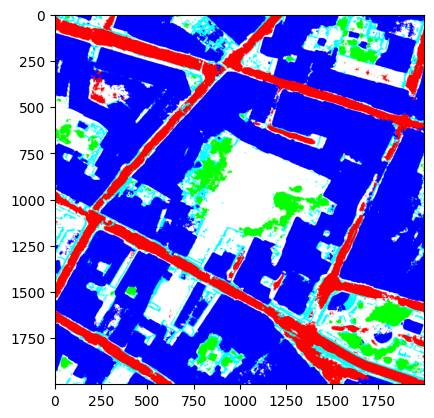

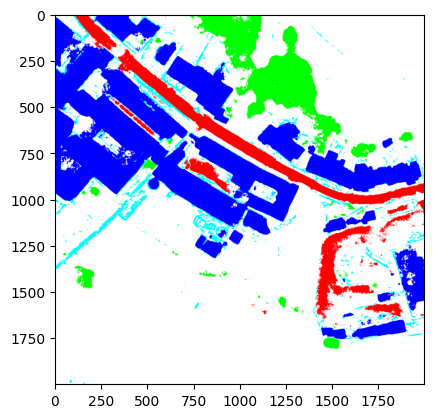

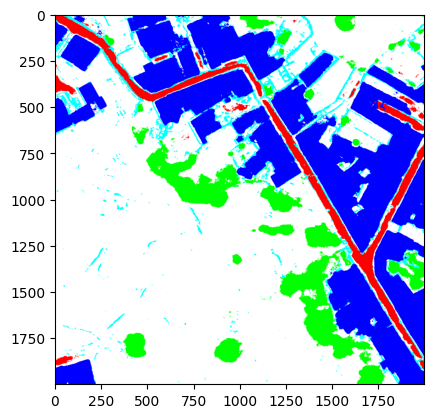

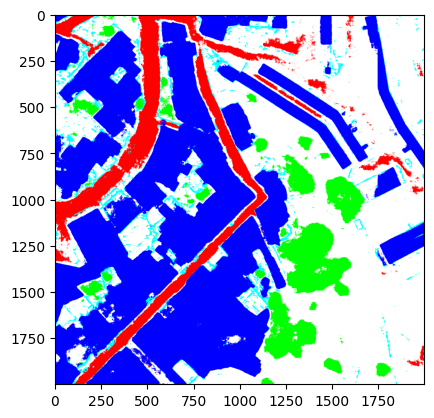

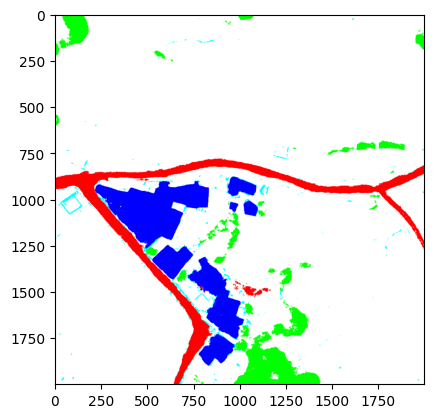

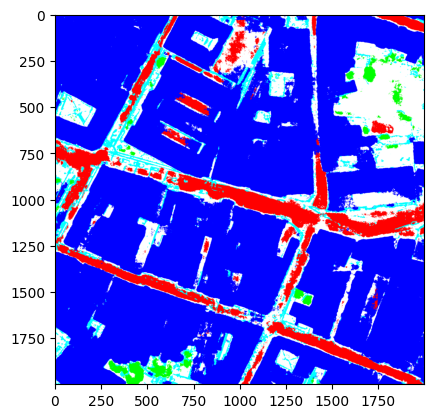

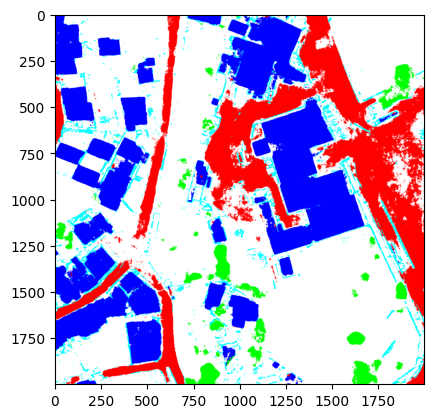

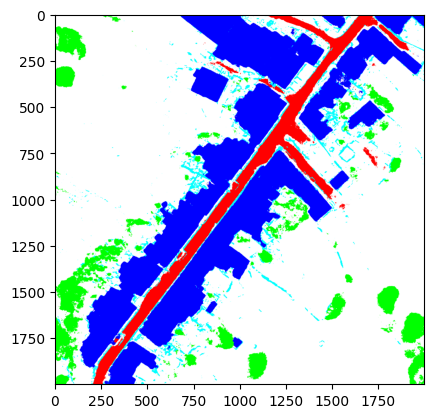

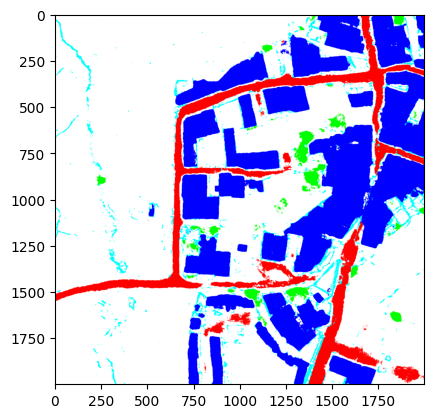

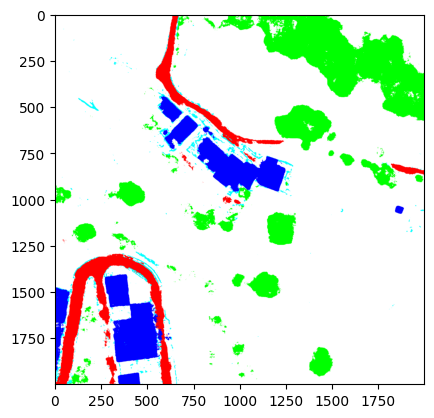

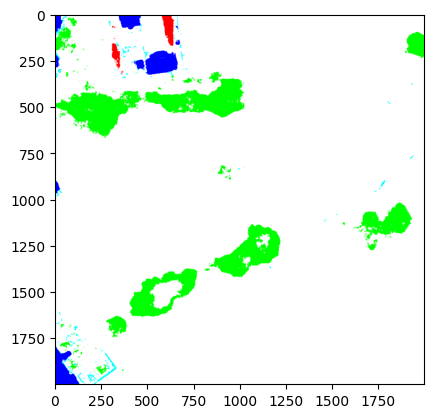

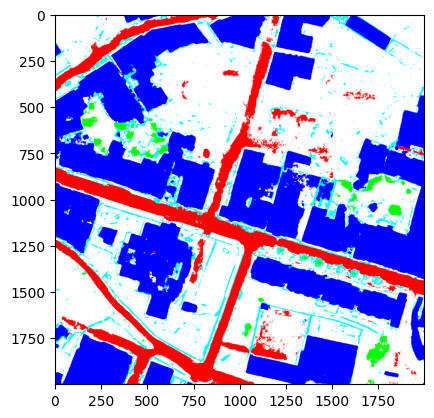

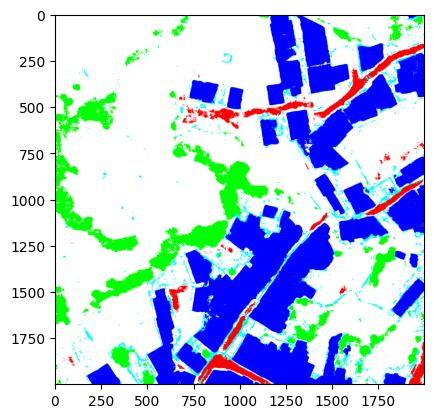

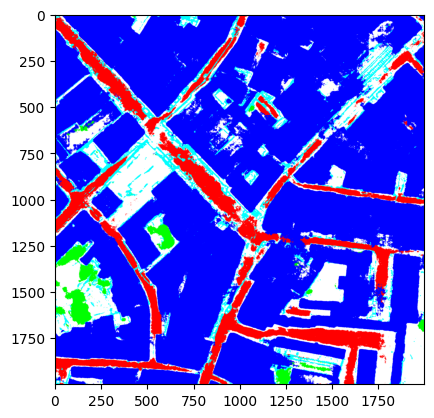

In [23]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt

# Recorrer cada predicción (p) y su ID correspondiente (id_) de los mosaicos de prueba
for p, id_ in zip(all_preds, test_ids):
    a = np.asarray(p)  # p puede ser (H,W) o (N,H,W)

    # caso 1: ya es una máscara 2D
    if a.ndim == 2:
        masks = [a]
        suffixes = [""]

    # caso 2: viene como lote (N,H,W) -> iteramos cada una
    elif a.ndim == 3:
        masks = [a[i] for i in range(a.shape[0])]
        suffixes = [f"_{i:03d}" for i in range(a.shape[0])]
        
     # Cualquier otra dimensión no es válida
    else:
        raise ValueError(f"Forma inesperada: {a.shape}")
        
    # Recorrer cada máscara individual (ya sea única o de un lote)
    for y, suf in zip(masks, suffixes):
        img = convert_to_color(y).astype(np.uint8)  # y es (H,W) con labels 0..4

        # Visualizar la predicción segmentada
        plt.imshow(img); plt.show()
        # Guardar el resultado como imagen PNG para evaluación cualitativa
        io.imsave('./inference_v2_tile_{}.png'.format(id_), img)